In [ ]:
Group Members - Aryan Bhosale 1032240128
              - Aryan Vankudre 1032232537


Country: France
Model used: Linear Regression (Trend + Month Dummies)
Test MAE : 837.68
Test RMSE: 1082.16
Test R²  : 0.642


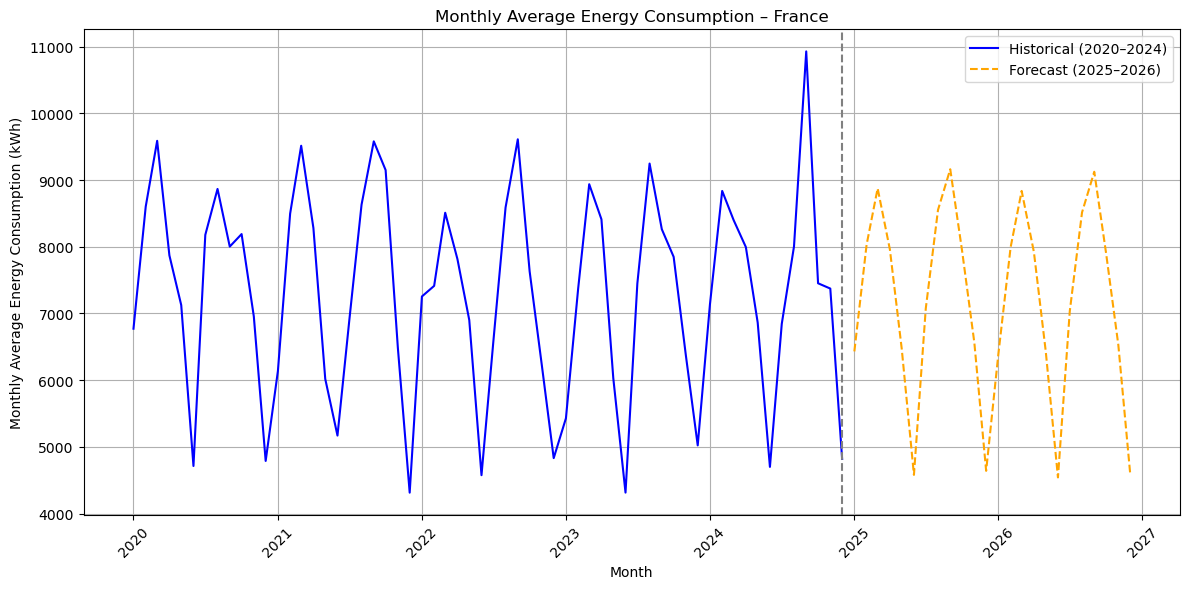


Country: Germany
Model used: Linear Regression (Trend + Month Dummies)
Test MAE : 456.49
Test RMSE: 600.11
Test R²  : 0.885


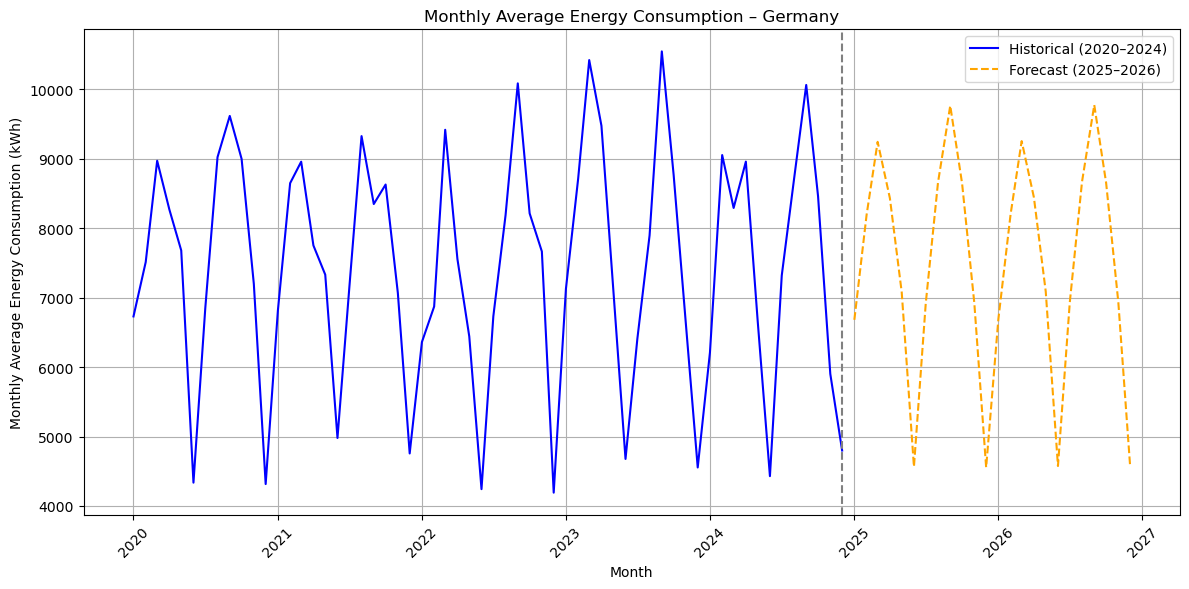


Country: Italy
Model used: Linear Regression (Trend + Month Dummies)
Test MAE : 474.29
Test RMSE: 736.87
Test R²  : 0.739


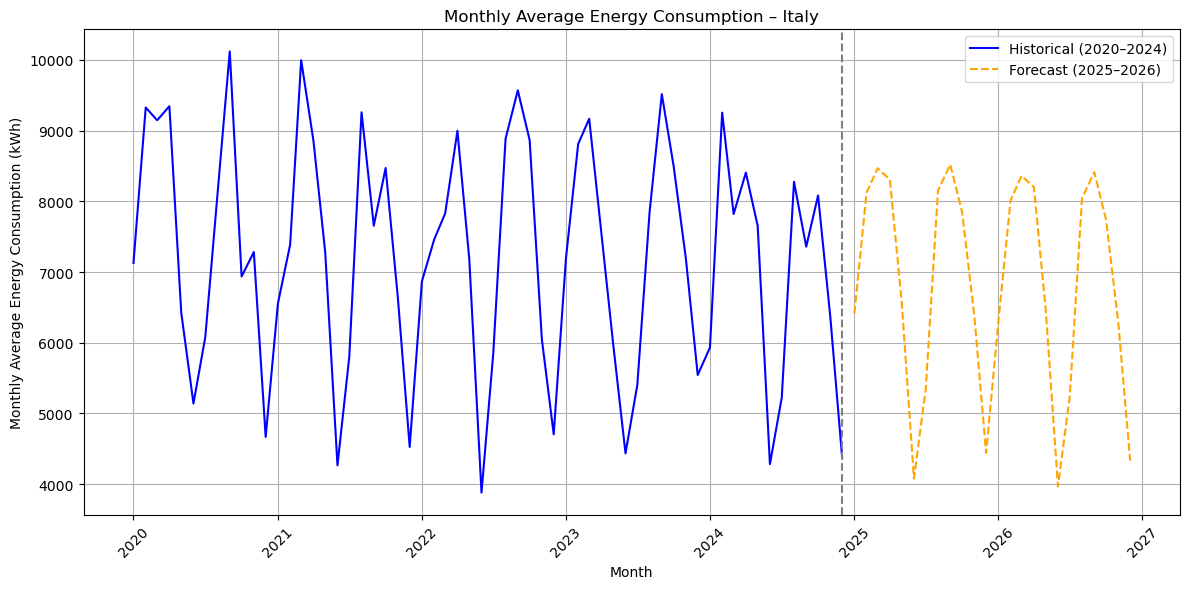


Country: Netherlands
Model used: Linear Regression (Trend + Month Dummies)
Test MAE : 446.16
Test RMSE: 472.22
Test R²  : 0.93


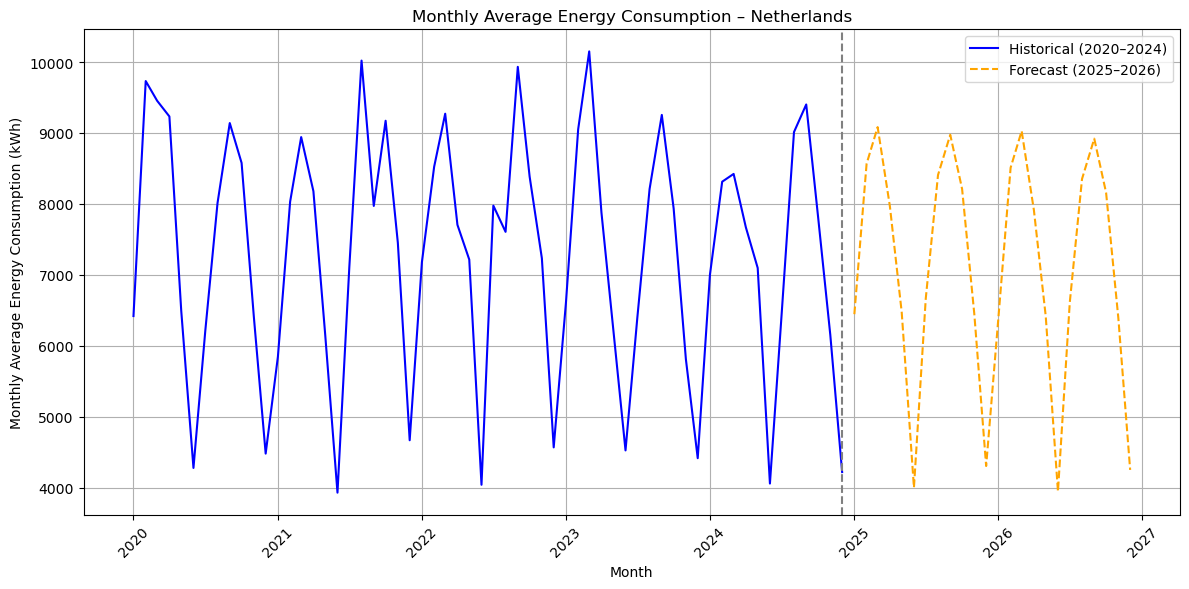


Country: Spain
Model used: Linear Regression (Trend + Month Dummies)
Test MAE : 771.08
Test RMSE: 1008.72
Test R²  : 0.61


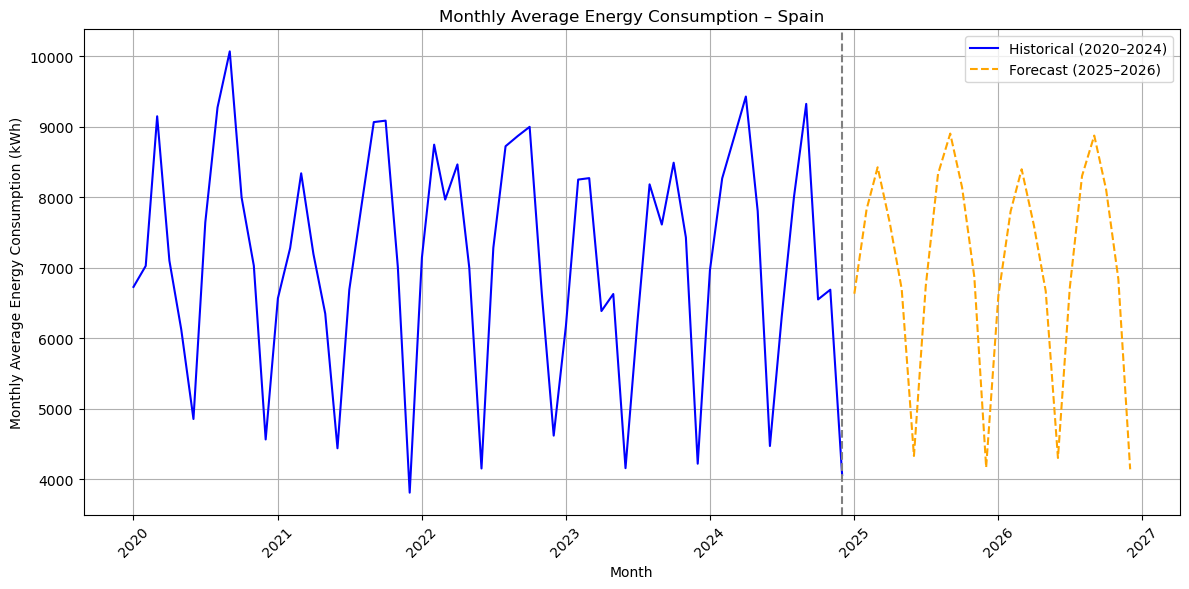

In [10]:
# =============================================================
# MONTHLY ENERGY FORECAST PER COUNTRY (WITH ACCURACY)
# Model: Linear Regression (Trend + Month Dummies)
# =============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =============================================================
# 1. LOAD DATA
# =============================================================
data = pd.read_csv(r"C:\\Users\\LENOVO\Downloads\\global_climate_energy_2020_2024.csv")


data['date'] = pd.to_datetime(data['date'], dayfirst=True)

# =============================================================
# 2. CREATE MONTHLY AVERAGE ENERGY CONSUMPTION
# =============================================================
data['year_month'] = data['date'].dt.to_period('M')

monthly = (
    data.groupby(['country', 'year_month'])['energy_consumption']
    .mean()
    .reset_index()
)

monthly['year_month'] = monthly['year_month'].dt.to_timestamp()

countries = monthly['country'].unique()[:5]   # only 5 countries


# =============================================================
# 3. FORECAST PER COUNTRY
# =============================================================
for country in countries:

    print("\n=================================================")
    print("Country:", country)
    print("Model used: Linear Regression (Trend + Month Dummies)")
    print("=================================================")

    country_data = monthly[monthly['country'] == country].copy()
    country_data = country_data.sort_values('year_month')
    country_data.set_index('year_month', inplace=True)

    # Ensure continuous monthly index
    full_range = pd.date_range(
        start=country_data.index.min(),
        end=country_data.index.max(),
        freq='MS'
    )
    country_data = country_data.reindex(full_range)

    country_data['energy_consumption'] = (
        country_data['energy_consumption'].interpolate()
    )

    series = country_data['energy_consumption']

    # Create Trend
    country_data['trend'] = np.arange(len(country_data))

    # Create Month Dummies
    country_data['month'] = country_data.index.month
    month_dummies = pd.get_dummies(
        country_data['month'],
        prefix='month',
        drop_first=True
    )

    X = pd.concat([country_data['trend'], month_dummies], axis=1)
    y = series.values

    # ----------------------------------------------------------
    # TRAIN / TEST SPLIT (last 6 months test)
    # ----------------------------------------------------------
    test_size = 6

    X_train = X[:-test_size]
    y_train = y[:-test_size]

    X_test = X[-test_size:]
    y_test = y[-test_size:]

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict test
    y_pred_test = model.predict(X_test)

    # ----------------------------------------------------------
    # ACCURACY METRICS
    # ----------------------------------------------------------
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)

    print("Test MAE :", round(mae, 2))
    print("Test RMSE:", round(rmse, 2))
    print("Test R²  :", round(r2, 3))

    # ----------------------------------------------------------
    # REFIT ON FULL DATA FOR FUTURE FORECAST
    # ----------------------------------------------------------
    model.fit(X, y)

    # Create future months (24 months)
    future_dates = pd.date_range(
        start=country_data.index.max() + pd.offsets.MonthBegin(1),
        periods=24,
        freq='MS'
    )

    future_df = pd.DataFrame(index=future_dates)
    future_df['trend'] = np.arange(len(country_data),
                                   len(country_data) + 24)
    future_df['month'] = future_df.index.month

    future_month_dummies = pd.get_dummies(
        future_df['month'],
        prefix='month',
        drop_first=True
    )

    future_month_dummies = future_month_dummies.reindex(
        columns=month_dummies.columns,
        fill_value=0
    )

    X_future = pd.concat([future_df['trend'],
                          future_month_dummies], axis=1)

    forecast_values = model.predict(X_future)

    forecast_series = pd.Series(
        forecast_values,
        index=future_dates
    )

    # ----------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------
    plt.figure(figsize=(12, 6))

    plt.plot(series.index, series.values,
             color='blue',
             label='Historical (2020–2024)')

    plt.plot(forecast_series.index,
             forecast_series.values,
             linestyle='--',
             color='orange',
             label='Forecast (2025–2026)')

    plt.axvline(pd.Timestamp("2024-12-01"),
                linestyle='--',
                color='gray')

    plt.title(f"Monthly Average Energy Consumption – {country}")
    plt.xlabel("Month")
    plt.ylabel("Monthly Average Energy Consumption (kWh)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
